In [ ]:
import json
import os
import time
from tqdm.notebook import tqdm
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

warnings.filterwarnings('ignore')

try:
    %run 02_interactive.ipynb
    print("\n--- Evaluation Setup ---")
    print("Successfully imported functions from '02_interactive.ipynb'.")
except Exception as e:
    print(f"\n--- ERROR ---")
    print(f"Could not run '02_interactive.ipynb'. Please ensure it runs without errors first.")
    print(f"Error details: {e}")

TEST_DATASET_PATH = os.path.join('data', 'test_dataset.json')
RESULTS_DIR = 'results'
CHART_PATH = os.path.join(RESULTS_DIR, 'comparison_chart.png')

os.makedirs(RESULTS_DIR, exist_ok=True)

try:
    with open(TEST_DATASET_PATH, 'r') as f:
        test_cases = json.load(f)
    print(f"Successfully loaded {len(test_cases)} test cases from '{TEST_DATASET_PATH}'.")
except FileNotFoundError:
    print(f"ERROR: Test dataset not found at '{TEST_DATASET_PATH}'. Please ensure the file exists.")

Ollama client initialized.
Successfully connected to local model 'phi3:mini'.
Embedding model loaded.
All indexes and metadata have been loaded successfully.
FAISS index contains 18 vectors.
Metadata contains information for 18 chunks.
--- Running Plagiarism Checks on Sample Code ---

[1] Pure Embedding Search:
{
  "is_plagiarized": false,
  "confidence_score": 0.5355204343795776,
  "explanation": "The most similar function found has a similarity score of 0.5355. The threshold for plagiarism is 0.9.",
  "most_similar_function": {
    "file_path": "data\\reference_corpus\\repo5\\14.py",
    "function_name": "bubblesort",
    "code": "def bubblesort(arr):\n    arr = arr.copy()\n    n = len(arr)\n    for i in range(n):\n        swapped = False\n        for j in range(0, n - i - 1):\n            if arr[j] > arr[j + 1]:\n                arr[j], arr[j + 1] = (arr[j + 1], arr[j])\n                swapped = True\n        if not swapped:\n            break\n    return arr"
  }
}

[3] Standard R

In [ ]:
def run_evaluation(test_data):
    results_list = []
    
    for case in tqdm(test_data, desc="Evaluating All Test Cases"):
        query_code = case['query_code']
        ground_truth = case['is_plagiarized']
        
        start_time = time.time()
        res_embedding = detect_embedding(query_code, similarity_threshold=0.8)
        duration = time.time() - start_time
        results_list.append({
            'method': 'Pure Embedding',
            'test_id': case['test_id'],
            'prediction': res_embedding['is_plagiarized'],
            'ground_truth': ground_truth,
            'duration': duration
        })

        start_time = time.time()
        res_rag = detect_rag(query_code)
        duration = time.time() - start_time
        results_list.append({
            'method': 'Standard RAG',
            'test_id': case['test_id'],
            'prediction': res_rag.get('is_plagiarized', False),
            'ground_truth': ground_truth,
            'duration': duration
        })

        start_time = time.time()
        res_hybrid = detect_hybrid_rag(query_code)
        duration = time.time() - start_time
        results_list.append({
            'method': 'Hybrid RAG',
            'test_id': case['test_id'],
            'prediction': res_hybrid.get('is_plagiarized', False),
            'ground_truth': ground_truth,
            'duration': duration
        })
        
    return pd.DataFrame(results_list)

print("Starting automated evaluation...")
results_df = run_evaluation(test_cases)
print("\nEvaluation complete!")
results_df.head()

Starting automated evaluation...


Evaluating All Test Cases:   0%|          | 0/30 [00:00<?, ?it/s]


Evaluation complete!


,method,test_id,prediction,ground_truth,duration
0,Pure Embedding,positive_001,False,True,0.084862
1,Standard RAG,positive_001,False,True,84.622017
2,Hybrid RAG,positive_001,True,True,125.342111
3,Pure Embedding,negative_001,True,False,0.052336
4,Standard RAG,negative_001,True,False,76.667794


In [ ]:
def calculate_metrics(df):
    metrics_list = []
    
    for method_name in df['method'].unique():
        subset = df[df['method'] == method_name]
        y_true = subset['ground_truth']
        y_pred = subset['prediction']
        
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average='binary', pos_label=True, zero_division=0
        )
        
        accuracy = accuracy_score(y_true, y_pred)
        
        avg_duration = subset['duration'].mean()
        
        metrics_list.append({
            'Method': method_name,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Avg Duration (s)': avg_duration
        })
        
    return pd.DataFrame(metrics_list).set_index('Method')

metrics_df = calculate_metrics(results_df)

print("--- Final Performance Metrics ---")
display(metrics_df)

--- Final Performance Metrics ---


,Accuracy,Precision,Recall,F1 Score,Avg Duration (s)
Method,,,,,
Pure Embedding,0.333333,0.222222,0.133333,0.166667,0.082057
Standard RAG,0.366667,0.375000,0.400000,0.387097,82.287807
Hybrid RAG,0.433333,0.375000,0.200000,0.260870,133.960480



Comparison chart successfully saved to: 'results\comparison_chart.png'


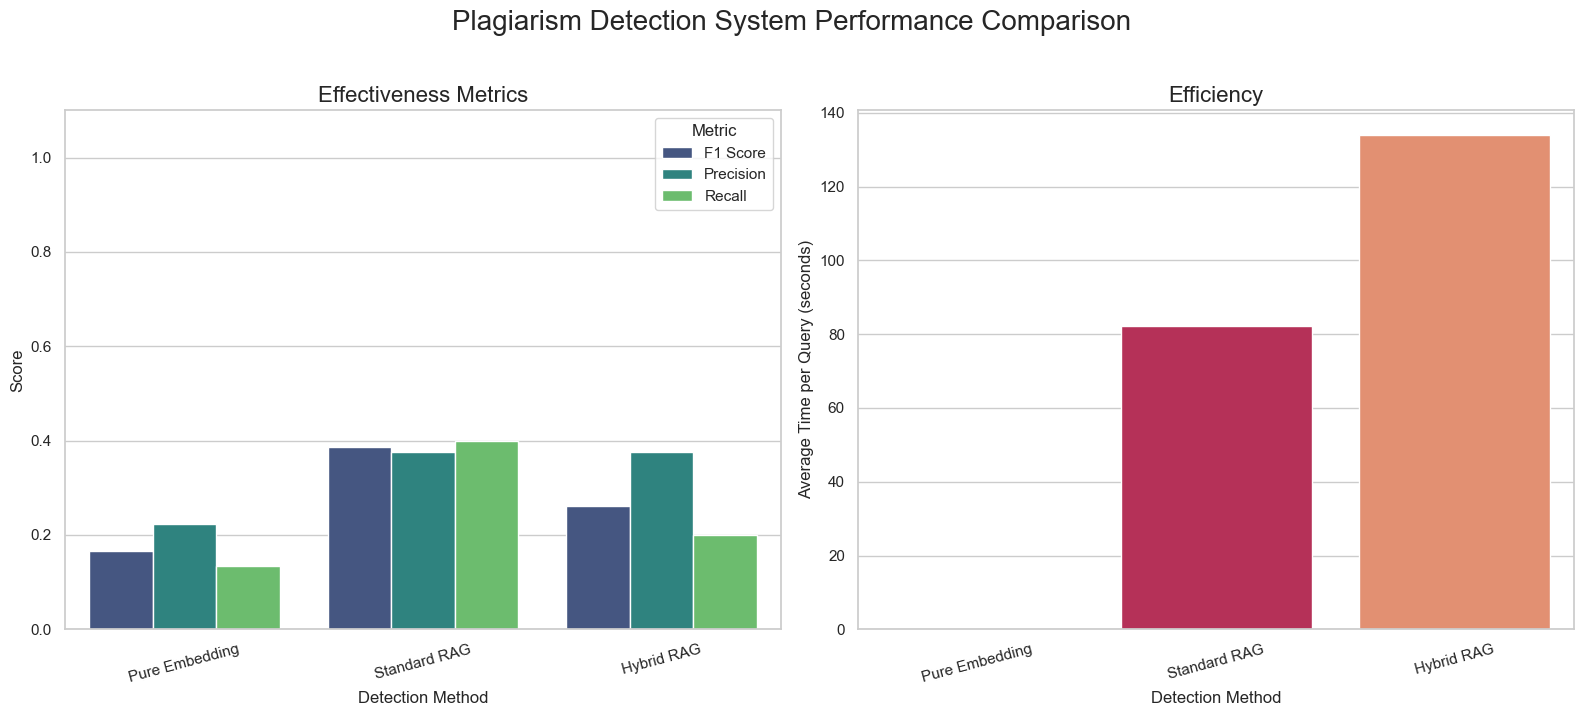

In [ ]:
sns.set_theme(style="whitegrid")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Plagiarism Detection System Performance Comparison', fontsize=20, y=1.02)

metrics_to_plot = metrics_df[['F1 Score', 'Precision', 'Recall']].reset_index().melt(
    id_vars='Method', 
    var_name='Metric', 
    value_name='Score'
)

sns.barplot(data=metrics_to_plot, x='Method', y='Score', hue='Metric', ax=ax1, palette='viridis')
ax1.set_ylabel('Score', fontsize=12)
ax1.set_xlabel('Detection Method', fontsize=12)
ax1.set_title('Effectiveness Metrics', fontsize=16)
ax1.set_ylim(0, 1.1)
ax1.tick_params(axis='x', rotation=15)

sns.barplot(data=metrics_df, x=metrics_df.index, y='Avg Duration (s)', ax=ax2, palette='rocket')
ax2.set_ylabel('Average Time per Query (seconds)', fontsize=12)
ax2.set_xlabel('Detection Method', fontsize=12)
ax2.set_title('Efficiency', fontsize=16)
ax2.tick_params(axis='x', rotation=15)

plt.tight_layout()

plt.savefig(CHART_PATH, bbox_inches='tight')

print(f"\nComparison chart successfully saved to: '{CHART_PATH}'")

plt.show()

In [ ]:
results_df.to_csv('results/main_evaluation_results.csv', index=False)

metrics_df.to_csv('results/main_metrics.csv')

print("Successfully saved the results of the first three methods to the 'results' folder.")

Successfully saved the results of the first three methods to the 'results' folder.


In [ ]:
def run_direct_llm_evaluation(test_data):
    results_list = []
    
    for case in tqdm(test_data, desc="Evaluating Direct LLM Method"):
        query_code = case['query_code']
        ground_truth = case['is_plagiarized']
        
        start_time = time.time()
        res_llm = detect_llm(query_code)
        duration = time.time() - start_time
        
        results_list.append({
            'method': 'Direct LLM',
            'test_id': case['test_id'],
            'prediction': res_llm.get('is_plagiarized', False),
            'ground_truth': ground_truth,
            'duration': duration
        })
        
    return pd.DataFrame(results_list)

print("Starting evaluation for the 'Direct LLM' method. This will be slow.")
direct_llm_results_df = run_direct_llm_evaluation(test_cases)

print("\n'Direct LLM' evaluation complete!")
direct_llm_results_df.head()

Starting evaluation for the 'Direct LLM' method. This will be slow.


Evaluating Direct LLM Method:   0%|          | 0/30 [00:00<?, ?it/s]


'Direct LLM' evaluation complete!


,method,test_id,prediction,ground_truth,duration
0,Direct LLM,positive_001,False,True,0.216985
1,Direct LLM,negative_001,False,False,0.118989
2,Direct LLM,positive_002,False,True,0.127904
3,Direct LLM,negative_002,False,False,0.126194
4,Direct LLM,positive_003,False,True,0.122820


--- All four methods have been combined. ---
method
Pure Embedding    30
Standard RAG      30
Hybrid RAG        30
Direct LLM        30
Name: count, dtype: int64

--- Final Performance Metrics (All Methods) ---


,Accuracy,Precision,Recall,F1 Score,Avg Duration (s)
Method,,,,,
Pure Embedding,0.333333,0.222222,0.133333,0.166667,0.082057
Standard RAG,0.366667,0.375000,0.400000,0.387097,82.287807
Hybrid RAG,0.433333,0.375000,0.200000,0.260870,133.960480
Direct LLM,0.500000,0.000000,0.000000,0.000000,0.143690



--- Generating Final Comparison Chart ---

Final comparison chart saved to: 'results\comparison_chart_all_methods.png'


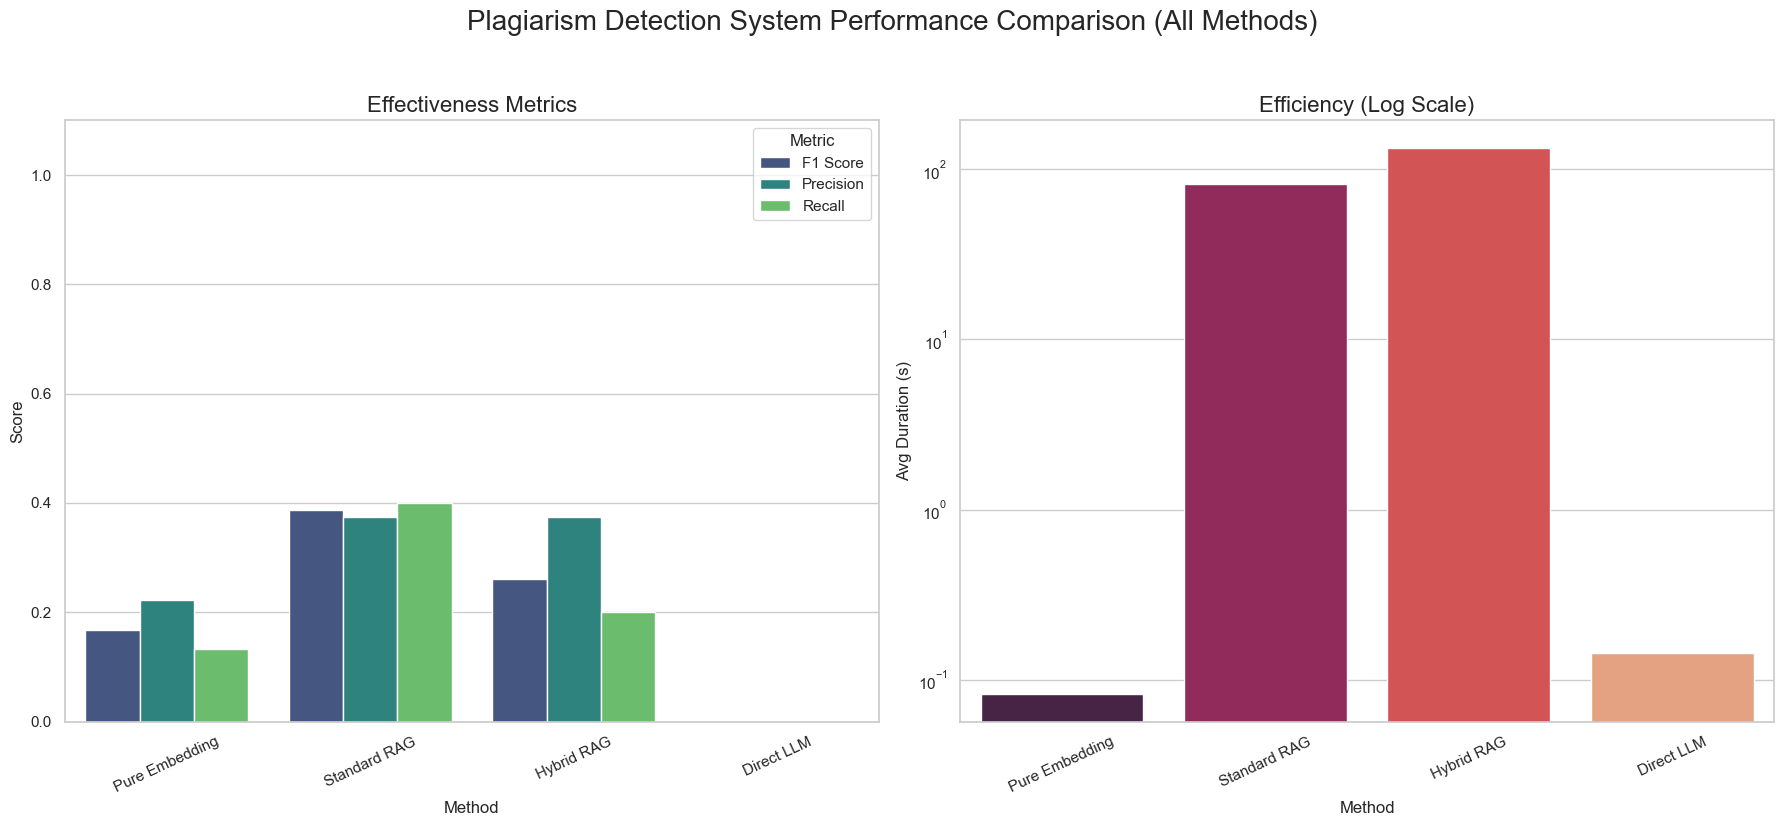

In [ ]:
main_results_df = pd.read_csv('results/main_evaluation_results.csv')

final_results_df = pd.concat([main_results_df, direct_llm_results_df], ignore_index=True)

print("--- All four methods have been combined. ---")
print(final_results_df['method'].value_counts())

print("\n--- Final Performance Metrics (All Methods) ---")
final_metrics_df = calculate_metrics(final_results_df)
display(final_metrics_df)

print("\n--- Generating Final Comparison Chart ---")

sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Plagiarism Detection System Performance Comparison (All Methods)', fontsize=20, y=1.03)

metrics_to_plot = final_metrics_df[['F1 Score', 'Precision', 'Recall']].reset_index().melt(
    id_vars='Method', var_name='Metric', value_name='Score'
)
sns.barplot(data=metrics_to_plot, x='Method', y='Score', hue='Metric', ax=ax1, palette='viridis')
ax1.set_title('Effectiveness Metrics', fontsize=16)
ax1.set_ylim(0, 1.1)
ax1.tick_params(axis='x', rotation=25)

sns.barplot(data=final_metrics_df, x=final_metrics_df.index, y='Avg Duration (s)', ax=ax2, palette='rocket')
ax2.set_title('Efficiency (Log Scale)', fontsize=16)
ax2.set_yscale('log')
ax2.tick_params(axis='x', rotation=25)

final_chart_path = os.path.join(RESULTS_DIR, 'comparison_chart_all_methods.png')
plt.tight_layout()
plt.savefig(final_chart_path, bbox_inches='tight')
print(f"\nFinal comparison chart saved to: '{final_chart_path}'")
plt.show()

--- All four methods have been combined. ---
method
Pure Embedding    30
Standard RAG      30
Hybrid RAG        30
Direct LLM        30
Name: count, dtype: int64

--- Final Performance Metrics (All Methods) ---

Final metrics table saved to 'results/final_metrics_all_methods.csv'


,Accuracy,Precision,Recall,F1 Score,Avg Duration (s)
Method,,,,,
Pure Embedding,0.333333,0.222222,0.133333,0.166667,0.082057
Standard RAG,0.366667,0.375000,0.400000,0.387097,82.287807
Hybrid RAG,0.433333,0.375000,0.200000,0.260870,133.960480
Direct LLM,0.500000,0.000000,0.000000,0.000000,0.143690



--- Generating Final Comparison Chart ---

Final comparison chart saved to: 'results\comparison_chart_all_methods.png'


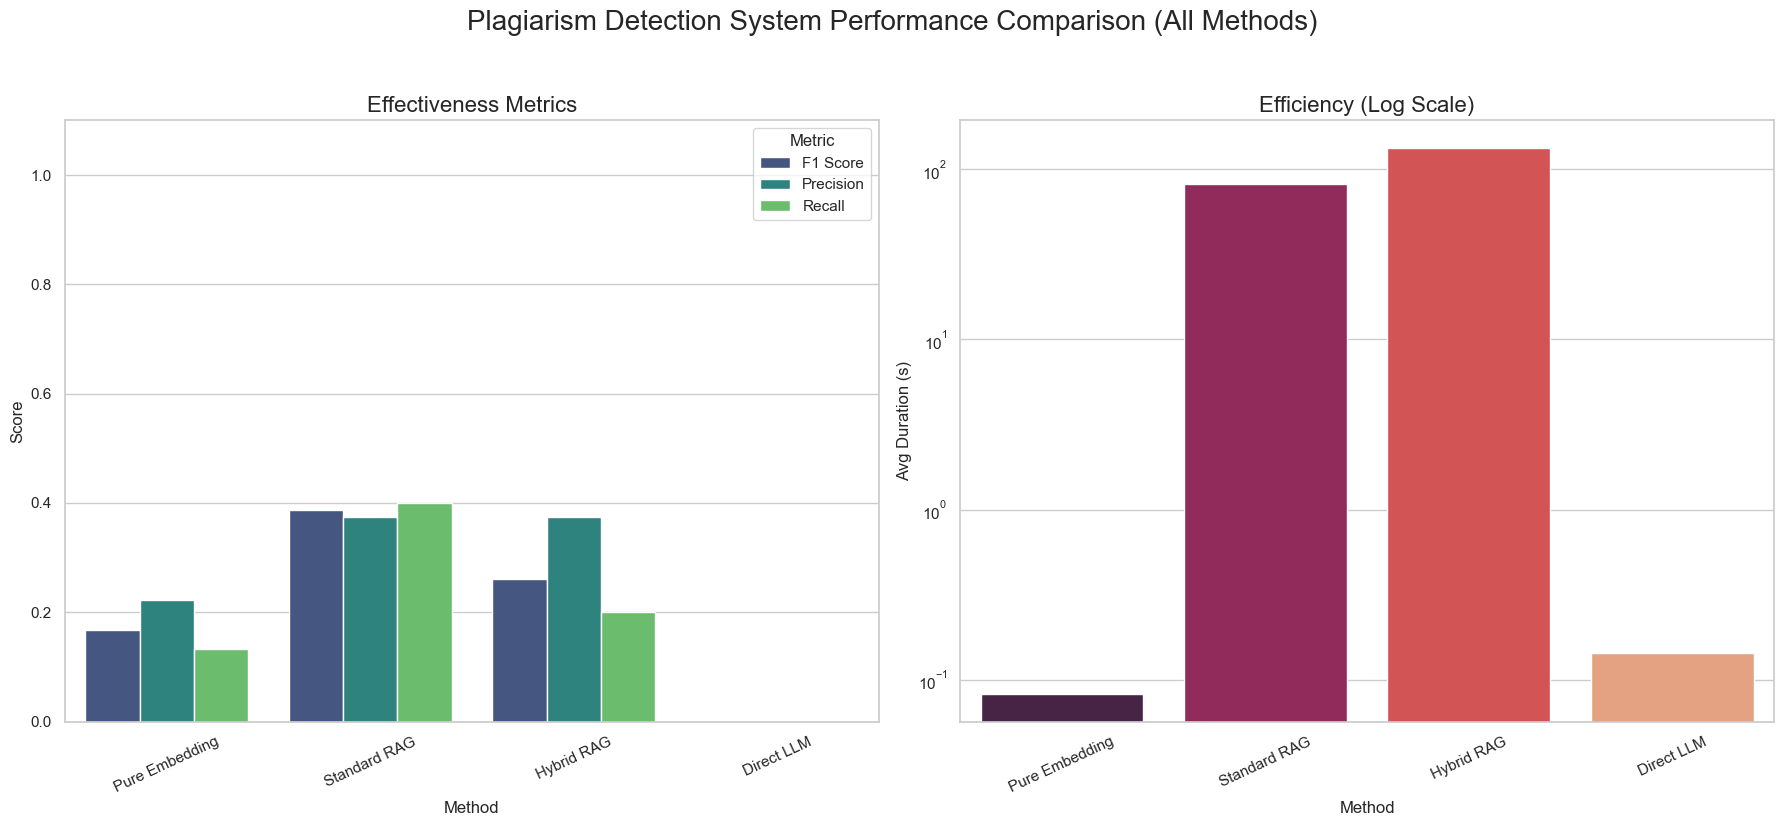

In [ ]:
try:
    main_results_df = results_df
except NameError:
    print("Loading main results from file...")
    main_results_df = pd.read_csv('results/main_evaluation_results.csv')

try:
    _ = direct_llm_results_df
except NameError:
    print("ERROR: The 'direct_llm_results_df' DataFrame was not found.")
    print("Please re-run the 'Separate Evaluation for the Direct LLM Method' cell first.")

final_results_df = pd.concat([main_results_df, direct_llm_results_df], ignore_index=True)

print("--- All four methods have been combined. ---")
print(final_results_df['method'].value_counts())

print("\n--- Final Performance Metrics (All Methods) ---")
final_metrics_df = calculate_metrics(final_results_df)

final_metrics_df.to_csv('results/final_metrics_all_methods.csv')
print("\nFinal metrics table saved to 'results/final_metrics_all_methods.csv'")

display(final_metrics_df)

print("\n--- Generating Final Comparison Chart ---")
sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
fig.suptitle('Plagiarism Detection System Performance Comparison (All Methods)', fontsize=20, y=1.03)

metrics_to_plot = final_metrics_df[['F1 Score', 'Precision', 'Recall']].reset_index().melt(
    id_vars='Method', var_name='Metric', value_name='Score'
)
sns.barplot(data=metrics_to_plot, x='Method', y='Score', hue='Metric', ax=ax1, palette='viridis')
ax1.set_title('Effectiveness Metrics', fontsize=16)
ax1.set_ylim(0, 1.1)
ax1.tick_params(axis='x', rotation=25)

sns.barplot(data=final_metrics_df, x=final_metrics_df.index, y='Avg Duration (s)', ax=ax2, palette='rocket')
ax2.set_title('Efficiency (Log Scale)', fontsize=16)
ax2.set_yscale('log')
ax2.tick_params(axis='x', rotation=25)

final_chart_path = os.path.join(RESULTS_DIR, 'comparison_chart_all_methods.png')
plt.tight_layout()
plt.savefig(final_chart_path, bbox_inches='tight')
print(f"\nFinal comparison chart saved to: '{final_chart_path}'")
plt.show()